In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd

from scipy import stats

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns
sns.set_context('talk')

from datetime import date

import random

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
mother_path = 'D:/Multi-modal project/behavior/inactivation/'
save_path = 'D:/Multi-modal project/analysis/result/figures/'

rat_list = ['874','876','903','904','905','907']
cond = ['Multimodal','Visual','Auditory','SimpleVisual']
cond_ab = ['M','V','A','C']
palette = ['mediumorchid','cornflowerblue','lightcoral','gray']

### Data preparation

In [4]:
result = []

for ratID in rat_list:
    rat_folder = mother_path+'LE'+ratID+'/test/'
    for c in cond:
        PBS = pd.read_csv(rat_folder+'1_Rat'+ratID+'_'+c+'Test_MainTask.csv')
        MUS = pd.read_csv(rat_folder+'2_Rat'+ratID+'_'+c+'Test_MainTask.csv')
        
        PBS.drop(PBS[PBS.NosepokeLatency==0].index,inplace=True)
        MUS.drop(MUS[MUS.NosepokeLatency==0].index,inplace=True)
        
        PBS.reset_index(inplace=True)
        MUS.reset_index(inplace=True)
        
        # remove multimodal trials from visual / auditory test sessions
        if (c=='Visual')|(c=='Auditory'):
            PBS = PBS.drop(range(1,21)).reset_index(drop=True)
            MUS = MUS.drop(range(1,21)).reset_index(drop=True)   
        
        PBS_result = {'Rat':ratID,
                      'Drug':'PBS',
                      'Modality':c,
                      'Correctness':np.mean(PBS.Correctness),
                      'LatencyMedian':np.median(PBS.TrialLatency),
                      'NosepokeAttempts':np.mean(PBS.NosepokeAttempts)}

        MUS_result = {'Rat':ratID,
                      'Drug':'MUS',
                      'Modality':c,
                      'Correctness':np.mean(MUS.Correctness),
                      'LatencyMedian':np.median(MUS.TrialLatency),
                      'NosepokeAttempts':np.mean(MUS.NosepokeAttempts)}        
        
        result.append(PBS_result)
        result.append(MUS_result)
df = pd.DataFrame(result)        

In [13]:
df.groupby(['Modality','Drug']).mean()

Correctness  LatencyMedian  NosepokeAttempts
Modality     Drug                                              
Auditory     MUS      0.611667       3.662500          1.263333
             PBS      0.741667       4.092500          1.370000
Multimodal   MUS      0.696851       4.914167          1.293080
             PBS      0.856944       4.322500          1.280556
SimpleVisual MUS      0.876550       4.824167          1.460675
             PBS      0.886283       5.729167          1.521889
Visual       MUS      0.590000       4.101667          1.291667
             PBS      0.730512       3.993333          1.216436

### Correctness analysis

In [6]:
pg.rm_anova(data=df, dv='Correctness',within=['Drug','Modality'],subject='Rat',detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Drug,0.145424,1,5,0.145424,165.397137,0.000051,0.000051,0.362159,1.000000
1,Modality,0.377039,3,15,0.125680,22.460199,0.000008,0.000729,0.595486,0.532703
2,Drug * Modality,0.041681,3,15,0.013894,1.949542,0.165023,0.195557,0.139961,0.635492


In [7]:
for i in cond:
    a = df.loc[(df['Drug']=='PBS')&(df['Modality']==i),'Correctness']
    b = df.loc[(df['Drug']=='MUS')&(df['Modality']==i),'Correctness']
    print(i,': ttest results')
    print(pg.ttest(a,b,paired=True,alternative='greater'))
    print('---------------------------------------------')

Multimodal : ttest results
               T  dof alternative    p-val        CI95%   cohen-d    BF10  \
T-test  3.716618    5     greater  0.00688  [0.07, inf]  1.858388  10.857   

          power  
T-test  0.98632  
---------------------------------------------
Visual : ttest results
               T  dof alternative     p-val        CI95%   cohen-d   BF10  \
T-test  2.387949    5     greater  0.031273  [0.02, inf]  1.565475  3.552   

           power  
T-test  0.946914  
---------------------------------------------
Auditory : ttest results
               T  dof alternative    p-val        CI95%   cohen-d   BF10  \
T-test  3.449842    5     greater  0.00912  [0.05, inf]  1.515664  8.793   

          power  
T-test  0.93507  
---------------------------------------------
SimpleVisual : ttest results
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  0.372762    5     greater  0.362303  [-0.04, inf]  0.184672  0.791   

           power  
T-test  0

In [8]:
def plot_by_cond(df,values,ymin,ymax,fontsize):
    gb_mean = df.groupby(['Modality','Drug'])[values].mean()
    gb_sem = df.groupby(['Modality','Drug'])[values].sem()
    
    fig,ax = plt.subplots(1,4,figsize=(8,5))
    for i,c in enumerate(cond):
        x = ['PBS','MUS']
        y = gb_mean.loc[c].reindex(x)
        yerr = gb_sem.loc[c].reindex(x)
        
        ax[i].bar(x=x,height=y,color=palette[i])
        ax[i].errorbar(x=x,y=y,yerr=yerr,color='black',linestyle='none')
        ax[i].set_ylim([ymin,ymax])
        ax[i].set_xlabel('Drug')
        ax[i].set_title(c,fontsize=fontsize)
        
        if i!=0:
            ax[i].tick_params(axis='both',left=False,labelleft=False)
            ax[i].set_ylabel('')
            ax[i].spines['left'].set_visible(False)
        else:
            ax[i].set_ylabel(values)

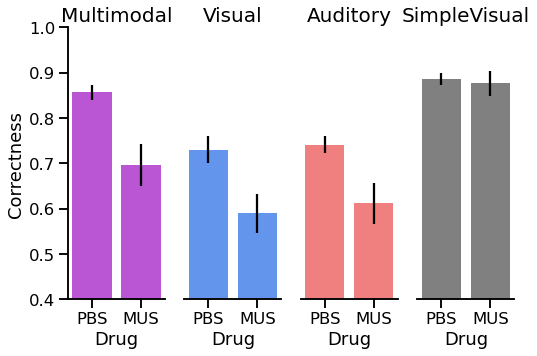

In [12]:
plot_by_cond(df,'Correctness',0.4,1,20)
plt.savefig(save_path+'Inactivation (performance).svg')

### Latency analysis
Control analysis showing that muscimol did not affect animals' basic motor behavior

In [13]:
pg.rm_anova(data=df, dv='LatencyMedian',within=['Drug','Modality'],subject='Rat',detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Drug,0.302419,1,5,0.302419,0.134744,0.728587,0.728587,0.002500,1.000000
1,Modality,14.416517,3,15,4.805506,2.572219,0.092850,0.132949,0.106708,0.603967
2,Drug * Modality,3.794773,3,15,1.264924,1.745486,0.200686,0.231214,0.030485,0.558393


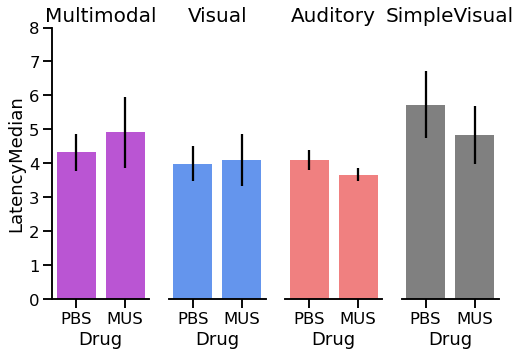

In [14]:
plot_by_cond(df,'LatencyMedian',0,8,20)
plt.savefig(save_path+'Inactivation (latency).svg')

### Nose-poke attempt analysis
Another control analysis showing that muscimol did not affect animals' motor behavior.

In [15]:
pg.rm_anova(data=df, dv='NosepokeAttempts',within=['Drug','Modality'],subject='Rat',detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Drug,0.004815,1,5,0.004815,0.917402,0.382146,0.382146,0.001928,1.000000
1,Modality,0.403380,3,15,0.134460,3.799856,0.032936,0.082058,0.139292,0.486629
2,Drug * Modality,0.058010,3,15,0.019337,1.472481,0.262042,0.278931,0.022744,0.529382


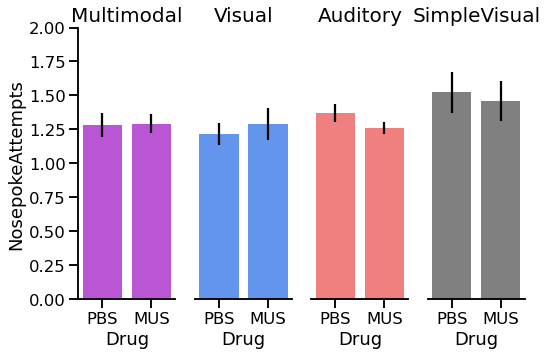

In [16]:
plot_by_cond(df,'NosepokeAttempts',0,2,20)
plt.savefig(save_path+'Inactivation (NosepokeAttempts).svg')

### Within-session learning of unimodal conditions
To examine if rats could learn and improve their performance in unmodal conditions (i.e., auditory or visual) within a session

In [14]:
V_culm_perf = np.zeros((len(rat_list),120))
A_culm_perf = np.zeros((len(rat_list),120))

for i,ratID in enumerate(rat_list):
    rat_folder = mother_path+'LE'+ratID+'/test/'
    
    V = pd.read_csv(rat_folder+'1_Rat'+ratID+'_VisualTest_MainTask.csv')
    A = pd.read_csv(rat_folder+'1_Rat'+ratID+'_AuditoryTest_MainTask.csv')
        
    V.drop(V[V.NosepokeLatency==0].index,inplace=True)
    A.drop(A[A.NosepokeLatency==0].index,inplace=True)        
    V.reset_index(inplace=True,drop=True)
    A.reset_index(inplace=True,drop=True)
        
    V_culm_perf[i,:] = V.loc[range(120),'Correctness'].cumsum()/V.loc[range(120),'Trial']
    A_culm_perf[i,:] = V.loc[range(120),'Correctness'].cumsum()/A.loc[range(120),'Trial']

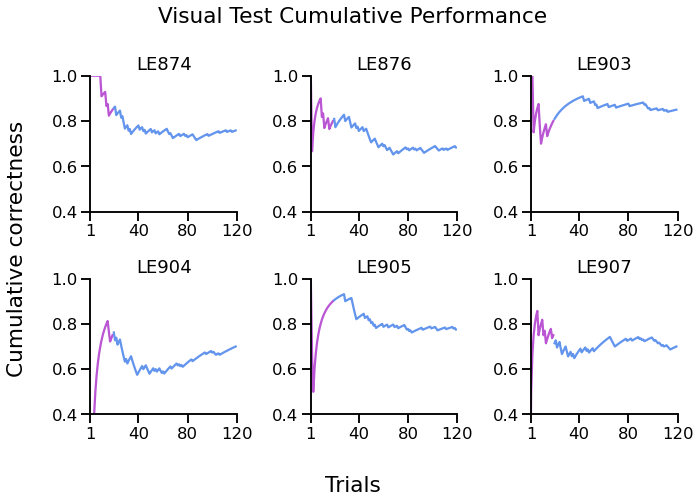

In [15]:
fig,ax = plt.subplots(2,3,figsize=(10,7))
        
for i in range(2):
    for j in range(3):
        ax[i,j].plot(range(20),V_culm_perf[i*3+j,range(20)],color=palette[0])
        ax[i,j].plot(range(20,120),V_culm_perf[i*3+j,range(20,120)],color=palette[1])
        ax[i,j].set_ylim([0.4,1])
        ax[i,j].set_xlim([1,120])
        ax[i,j].set_xticks([1,40,80,120])
        ax[i,j].set_title('LE'+rat_list[i*3+j])

fig.suptitle('Visual Test Cumulative Performance')
fig.supylabel('Cumulative correctness')
fig.supxlabel('Trials')
fig.tight_layout()

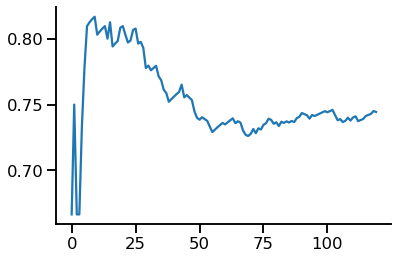

In [16]:
a = np.sum(V_culm_perf,axis=0)/len(rat_list)
plt.plot(a)
plt.show()

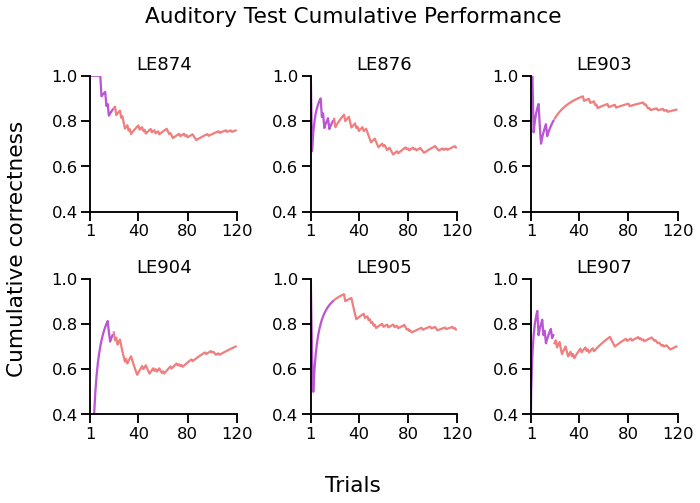

In [17]:
fig,ax = plt.subplots(2,3,figsize=(10,7))
        
for i in range(2):
    for j in range(3):
        ax[i,j].plot(range(20),A_culm_perf[i*3+j,range(20)],color=palette[0])
        ax[i,j].plot(range(20,120),A_culm_perf[i*3+j,range(20,120)],color=palette[2])
        ax[i,j].set_ylim([0.4,1])
        ax[i,j].set_xlim([1,120])
        ax[i,j].set_xticks([1,40,80,120])
        ax[i,j].set_title('LE'+rat_list[i*3+j])

fig.suptitle('Auditory Test Cumulative Performance')
fig.supylabel('Cumulative correctness')
fig.supxlabel('Trials')
fig.tight_layout()

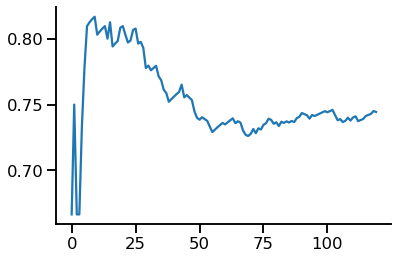

In [19]:
a = np.sum(A_culm_perf,axis=0)/len(rat_list)
plt.plot(a)
plt.show()

Go to 'D:\Multi-modal project\analysis\matlab\behavior' and run more advanced analysis on the learning curve (Smith et al., 2004; Jin and Lee, 2021).

***
